In [1]:
# !nvidia-smi
from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
drive.mount('/content/gdrive')
!ls
%cd gdrive/My\ Drive/phd-thesis/
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
gdrive	sample_data
/content/gdrive/My Drive/phd-thesis
 adasyn_TL_MajorVoting_balance.ipynb
 ADASYN_TL_MajorVoting_imb.ipynb
 adasyn_xgboost_20_imb.ipynb
 adasyn_xgboost_20.ipynb
 adasyn_xgboost_fulldata_balance.ipynb
 adasyn_xgboost_fulldata_imb.ipynb
 Attack_Types.csv
'bagging&ensemble.py'
 cnn.docx
 cnn.ipynb
 CNN-test-data
 CNN-test-data-balanced
 CNN-test-data-balanced-dropout
 CNN-test-data-imb
 createCNN_Balanced_fulldata.ipynb
 createCNN_Balanced.ipynb
 createNetwork-211025.py
 createNetwork-CNN-imb.ipynb
'createNetwork-testdata (1).ipynb'
 createNetwork-testdata.ipynb
 createNetwork-testdata.py
 ensemble_balance-old.ipynb
 ensemble_imb-old.ipynb
 Evaluate_adasyn_xgboost_fulldata_balance.ipynb
 Evaluate_adasyn_xgboost_fulldata_imb.ipynb
 Evaluate_adasyn_xgboost_model_20.ipynb
 evaluate_auc_3Algorithm_macro.ipynb
 evaluate_auc_3Algorithm_micro.ipynb


In [9]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jun  8 10:12:36 2022
using Random undersampling on majority class
balanced on trainning data
@author: Administrator
"""

from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, zero_one_loss, classification_report, ConfusionMatrixDisplay
# , \     plot_confusion_matrix
    
from collections import Counter
from sklearn.metrics import accuracy_score
import sys
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
# import xgboost as xgb
import multiprocessing
import joblib
from sklearn.ensemble import AdaBoostClassifier #as adb
from imblearn.metrics import classification_report_imbalanced
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

#traing dataset
train_x = pd.read_csv('KDDTrain_x.csv',header=None)
train_Y = pd.read_csv('KDDTrain_y.csv',header=None)
train_x.drop(train_x.columns[[115,116,117]], axis=1, inplace=True)  #drop unused columns
train_Y[0]=list(train_Y[0].map({'benign':0, 'dos':1, 'probe':2, 'r2l':3, 'u2r':4}))

print("train_x", train_x.head())
print("train_y", train_Y.head())

#testing dataset
test_x = pd.read_csv('KDDTest_x.csv',header=None)
test_Y = pd.read_csv('KDDTest_y.csv',header=None)
test_x.drop(test_x.columns[[115,116,117]], axis=1, inplace=True)
test_Y[0]=list(test_Y[0].map({'benign':0, 'dos':1, 'probe':2, 'r2l':3, 'u2r':4}))
print("test_x", test_x.head())
print("test_y", test_Y.head())

# train_Y = train_Y.values.ravel()
# test_Y  = test_Y.values.ravel()
# print('Original dataset shape %s' % Counter(train_Y))

train_Y = train_Y.values.ravel()
test_Y  = test_Y.values.ravel()
print('Original train dataset shape %s' % Counter(train_Y))
print('Original test dataset shape %s' % Counter(test_Y))

######--------------- RandomUnderSampler-------------------------
mean_class_size = int(pd.Series(train_Y).value_counts().sum()/5)
print("mean_class_size", mean_class_size)

# reduce class 0 and 1 to mean class size
ratio= {0: mean_class_size,
     1: mean_class_size
     #'probe': mean_class_size,
     #'r2l': mean_class_size,
     #'u2r': mean_class_size
     }

# check if ratio para is still used
# print("before \n", pd.Series(train_Y).value_counts())
# print('Original dataset shape %s' % Counter(train_Y))

#from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=ratio, random_state=42)
# rus = RandomUnderSampler(sampling_strategy='majority', random_state=42)
train_x, train_Y = rus.fit_resample(train_x, train_Y)
print('now dataset shape %s' % Counter(train_Y))

train_x         0         1         2    3         4         5         6         7    \
0 -0.110249 -0.007679 -0.004919    0 -0.089486 -0.007736 -0.095076 -0.027023   
1 -0.110249 -0.007737 -0.004919    0 -0.089486 -0.007736 -0.095076 -0.027023   
2 -0.110249 -0.007762 -0.004919    0 -0.089486 -0.007736 -0.095076 -0.027023   
3 -0.110249 -0.007723 -0.002891    0 -0.089486 -0.007736 -0.095076 -0.027023   
4 -0.110249 -0.007728 -0.004814    0 -0.089486 -0.007736 -0.095076 -0.027023   

   8         9    ...  105  106  107  108  109  110  111  112  113  114  
0    0 -0.011664  ...    0    0    0    0    0    0    0    0    0    0  
1    0 -0.011664  ...    0    0    0    0    0    0    0    0    0    0  
2    0 -0.011664  ...    0    0    0    0    0    0    0    1    0    0  
3    1 -0.011664  ...    0    0    0    0    0    0    0    0    0    0  
4    1 -0.011664  ...    0    0    0    0    0    0    0    0    0    0  

[5 rows x 115 columns]
train_y    0
0  0
1  0
2  1
3  0
4  0
test_

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.9948328212767441
{'base_estimator__max_depth': 6, 'base_estimator__min_samples_leaf': 10, 'learning_rate': 0.1, 'n_estimators': 200}
test result: 
 [[9457   61  192    0    1]
 [1367 5988  281    0    0]
 [ 651  162 1610    0    0]
 [2565    0    3    3    3]
 [ 167    0   23    2    8]]
test error: 0.24299148332150466
test validation: 0.7570085166784953
              precision    recall  f1-score   support

    benign 0       0.67      0.97      0.79      9711
       dos 1       0.96      0.78      0.86      7636
     probe 2       0.76      0.66      0.71      2423
       r2l 3       0.60      0.00      0.00      2574
       u2r 4       0.67      0.04      0.08       200

    accuracy                           0.76     22544
   macro avg       0.73      0.49      0.49     22544
weighted avg       0.77      0.76      0.71     22544

                   pre       rec       spe        f1       geo       iba       sup

   benign 0     0.6657    0.9738    0.6299    0.7908    0.7832    0.

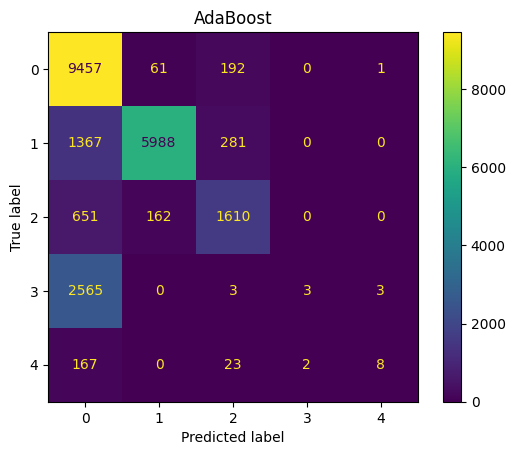

In [11]:
# xgb_model = xgb.XGBClassifier()

adb_model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
# clf = GridSearchCV(adb_model, {'max_depth': [2, 4, 6], 'n_estimators': [50, 100, 200]}, verbose=1, n_jobs=2)


# param_grid = [
#     {'max_depth': [2, 4, 6], 'n_estimators': [50, 100, 200]}, 
#     {'objective': ['multi:softmax'], 'verbose': [1], 'n_jobs':[-1]},
#     ]
    
param_grid = {'base_estimator__max_depth': [2, 4, 6],       #[i for i in range(2,11,2)]
        'base_estimator__min_samples_leaf':[5,10],
        'n_estimators':[50, 100, 200],
        'learning_rate':[0.01, 0.1]
        } 
        
    

# clf = GridSearchCV(xgb_model, {'max_depth': [2, 4, 6],
#                                'n_estimators': [50, 100, 200]}, verbose=1,
#                                 n_jobs=-1)
# clf = GridSearchCV(xgb_model, param_grid, cv=2)

# clf = GridSearchCV(xgb_model, param_grid, cv=5)
clf = GridSearchCV(adb_model, param_grid, cv=5, n_jobs=-1)

clf.fit(train_x, train_Y)

# save model
# clf.best_estimator_.save_model('myRUSBoost.json')
joblib.dump(clf, "myRUSBoost.pkl")

print(clf.best_score_)
print(clf.best_params_)


#evaluation with no sampling on test data
#pred_y = xgb_model.predict(x_test)
pred_y = clf.predict(test_x)
results = confusion_matrix(test_Y, pred_y)
error = zero_one_loss(test_Y, pred_y)
target_names = ['benign 0', 'dos 1', 'probe 2', 'r2l 3', 'u2r 4']

print("test result: \n" , results)
print("test error:", error)
# print("validation:", accuracy_score(test_Y, pred_y))
print("test validation:", accuracy_score(test_Y, pred_y))
print(classification_report(test_Y, pred_y, target_names=target_names))
print(classification_report_imbalanced(test_Y, pred_y, digits=4,target_names=target_names))

cm = confusion_matrix(test_Y, pred_y, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
_ = disp.ax_.set_title("AdaBoost")
plt.show()





In [ ]:
# from sklearn.model_selection import cross_val_score
# from sklearn.datasets import load_iris
# from sklearn.ensemble import AdaBoostClassifier

# X, y = load_iris(return_X_y=True)
# clf = AdaBoostClassifier(n_estimators=100)
# scores = cross_val_score(clf, X, y, cv=5)
# scores.mean()